In [90]:
import importlib
from tqdm import tqdm
from IPython.display import display_latex

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import  DateFormatter, num2date
import numpy as np
from datetime import datetime

import supermattercore.model as smm
# from supermattercore.model import SmModel
importlib.reload(smm)
importlib.reload(smm.pumps)
%config Application.logging_config = {'loggers': {'ct.sm': {'propagate': True, 'level': 'DEBUG', 'handlers': ['console']}}}

Total canister count in Engineering:
- 13x N2 /engine
- 4x H2
- 4x O2/ cryo
- 4x O2
- 4x CO2
- 4x He

In [72]:
canister_stock = {
    "N2/engine": 13,
    "O2/cryo":   4,
    "O2":        4,
    "H2":        4,
    "CO2":       4,
    "He":        4,
}

In [106]:
m = smm.SmModel()
for i in tqdm(range(3)):
    for _ in range(60):
        m.pump_cold()
        m.pump_hot_teg()
    if i < 2:
        m.c_hot.gases['']  = smm.pipes.mk_canister('He', engine=True)
        m.c_cold.gases[''] = smm.pipes.mk_canister('He', engine=True)
    display_latex(m.smcore)
stable = None
failing = None
m.energize_core(8)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.40it/s]


In [107]:
tiems = []
datums = []

In [114]:
T0 = m.smcore.room.T * 1 - 5
datums = [*datums]
for i in tqdm(range(5000)):
    m.full_tick()
    tiems.append(m.reftime)
    datums.append([m.smcore.room.T, m.smcore.eer, m.smcore.health, m.teg_pwr, m.core_room.X.get('O2',0), m.core_room.X.get('Ex*',0)])

    if i % 50 == 0:
        if m.smcore.room.T < T0:
            if stable is None:
                print(f'stable-ish? {m.reftime} @ {T0} K')
                stable = m.reftime
                # break
        T0 = m.smcore.room.T * 1
        if T0>5000:
            if failing is None:
                print(f'failure imminent {m.reftime} @ {T0} K')
                failing = m.reftime
        if m.smcore.health <= 0:
            print(f'delam {m.reftime}')
            break

100%|██████████| 5000/5000 [00:06<00:00, 832.27it/s]


In [115]:
(tiems[-1])

datetime.timedelta(seconds=16360)

Text(0.5, 0.98, '6 He:6 He @ 8x')

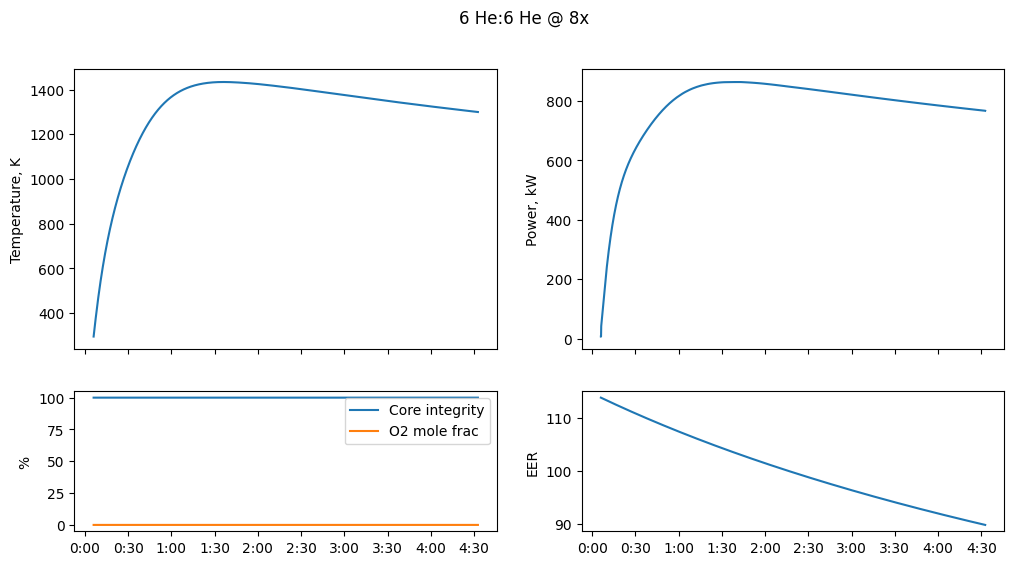

In [117]:
datums = np.array(datums)
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12,6), height_ratios=[0.4, 0.2])
refdate = datetime(2024,1,1,0,0,0,tzinfo=num2date(0).tzinfo)
axs[1][0].xaxis.set_major_formatter(FuncFormatter(lambda x,_: f'{(num2date(x)-refdate)}'[:-3]))
axs[0][0].plot([refdate+x for x in tiems], datums[:,0])
axs[0][0].set_ylabel('Temperature, K')
axs[0][1].plot([refdate+x for x in tiems], datums[:,3]/1e3)
axs[0][1].set_ylabel('Power, kW')
axs[1][0].plot([refdate+x for x in tiems], datums[:,2]/10, label='Core integrity')
axs[1][0].plot([refdate+x for x in tiems], datums[:,4]*100, label='O2 mole frac')
axs[1][0].legend()
axs[1][0].set_ylabel('%')
axs[1][1].plot([refdate +x for x in tiems], datums[:,1])
axs[1][1].set_ylabel('EER')
fig.suptitle('6 He:6 He @ 8x')

Text(0, 0.5, 'EER')

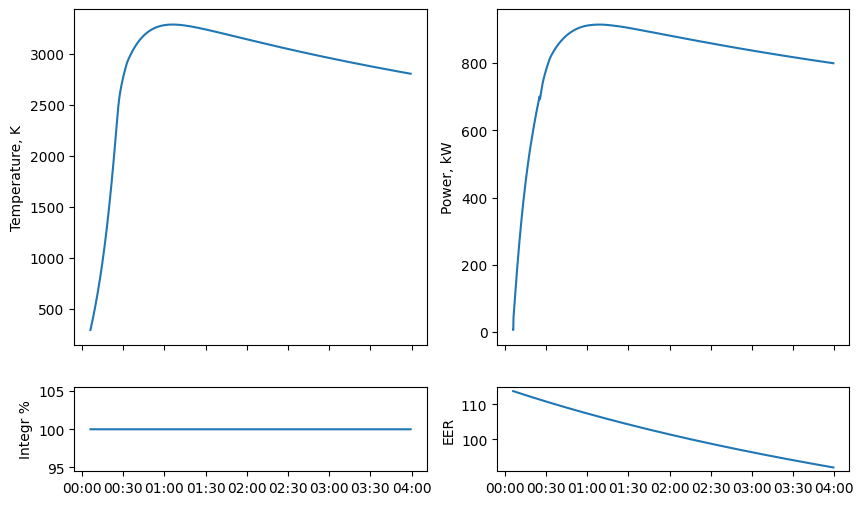

In [70]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,6), height_ratios=[0.4, 0.1])
axs[1][0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axs[0][0].plot([datetime(2024,5,27,0,0,0) +x for x in tiems], datums[:,0])
axs[0][0].set_ylabel('Temperature, K')
axs[0][1].plot([datetime(2024,5,27,0,0,0) +x for x in tiems], datums[:,3]/1e3)
axs[0][1].set_ylabel('Power, kW')
axs[1][0].plot([datetime(2024,5,27,0,0,0) +x for x in tiems], datums[:,2]/10)
axs[1][0].set_ylabel('Integr %')
axs[1][1].plot([datetime(2024,5,27,0,0,0) +x for x in tiems], datums[:,1])
axs[1][1].set_ylabel('EER')

In [55]:
m.waste

PipeNetwork(gases={'waste': GasMixture(T=1292.0155438743893, V=0.385, nus={'O2': 535.0148261935996, 'Ex*': 2.8724579990239403}), 'F1_o': GasMixture(T=1292.0155438743893, V=0.5, nus={'O2': 694.8244496020774, 'Ex*': 3.7304649337973252}), 'F2_o': GasMixture(T=1292.0155438743893, V=0.5, nus={'O2': 694.8244496020774, 'Ex*': 3.7304649337973252})})

In [16]:
m.smcore.health

-216.89393890075007

In [ ]:
%config Application.log_level = 10
m.full_tick()
%config Application.log_level = 30
